In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
import random

In [3]:
%%capture
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link_train = 'https://drive.google.com/file/d/1CYeQs6vrKW_S2MK53YWnbAfnKy_gOP3Q/view?usp=drive_link'
link_test = 'https://drive.google.com/file/d/1YlfA8loignkLb6lPZqUxQ3vWgDlsqk7V/view?usp=drive_link'

id_train = link_train.split("/")[-2]
id_test = link_test.split("/")[-2]

downloaded_train = drive.CreateFile({'id':id_train})
downloaded_test = drive.CreateFile({'id':id_test})
downloaded_train.GetContentFile('train1.csv')
downloaded_test.GetContentFile('test1.csv')

train_data = pd.read_csv('train1.csv', sep="\t", header=None)
test_data = pd.read_csv('test1.csv', sep="\t", header=None)

train_data = train_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)

X_train = train_data[0].to_numpy().reshape((len(train_data), 1))
X_test = test_data[0].to_numpy().reshape((len(test_data), 1))
y_train = train_data[1].to_numpy().reshape((len(train_data), 1))
y_test = test_data[1].to_numpy().reshape((len(test_data), 1))

In [4]:
class NeuralNetwork:
    def __init__(self, input_size=1, hidden_size=None):
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.b_output = np.random.randn(1)

      if hidden_size is not None:
          fan_in = input_size
          fan_out = hidden_size
          std = np.sqrt(2.0 / (fan_in + fan_out))
          self.w_input_hidden = np.random.randn(input_size, hidden_size) * std
          self.w_hidden_output = np.random.randn(hidden_size, 1) * std
          self.b_hidden = np.random.randn(hidden_size)
          self.w_input_output = None
      else:
          fan_in = input_size
          fan_out = 1
          std = np.sqrt(2.0 / (fan_in + fan_out))
          self.w_input_output = np.random.randn(input_size, 1) * std
          self.w_input_hidden = None
          self.w_hidden_output = None
          self.b_hidden = None

    def sigmoid(self, x):
        return expit(x)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def sse(self, actual, predicted):
        return np.sum(np.square(actual - predicted))

    def mse(self, actual, predicted):
        loss = np.square(actual - predicted)
        mse = np.mean(loss)
        return mse

    def mae(self, actual, predicted):
        return np.sum(np.abs(actual - predicted)) / len(actual)

    def r2(self, actual, predicted):
        r = np.corrcoef(actual.squeeze(), predicted.squeeze())[0, 1]
        return r ** 2

    def std_dev(self, actual, predicted):
        losses = np.square(actual - predicted)
        return np.std(losses)

    def forward_propagation(self, x):
        if self.hidden_size is not None:
            self.hidden_layer_output = self.sigmoid((x @ self.w_input_hidden ) + self.b_hidden)
            self.output = (self.hidden_layer_output @ self.w_hidden_output) + self.b_output
        else:
            self.output = (x @ self.w_input_output) + self.b_output

    def backward_propagation(self, x, y, learning_rate):
        output_error = -2*(y - self.output)
        if self.hidden_size is not None:
            hidden_error = output_error @ self.w_hidden_output.T
            hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_layer_output)
            self.w_hidden_output -= (self.hidden_layer_output.T @ output_error) * learning_rate
            self.w_input_hidden -= (x.T @ hidden_delta) * learning_rate
            self.b_output -= np.sum(output_error) * learning_rate
            self.b_hidden -= np.sum(hidden_delta) * learning_rate
        else:
            self.w_input_output -= x.T @ output_error * learning_rate
            self.b_output -= np.sum(output_error) * learning_rate

    def train(self, X, y, epochs, learning_rate):
            for epoch in range(epochs):
                random_index = np.random.randint(len(X))
                random_X = X[random_index]
                random_y = y[random_index]

                self.forward_propagation(random_X.reshape(-1, 1))
                self.backward_propagation(random_X.reshape(-1, 1), random_y.reshape(-1, 1), learning_rate)

    def predict(self, X):
        self.forward_propagation(X)
        return self.output

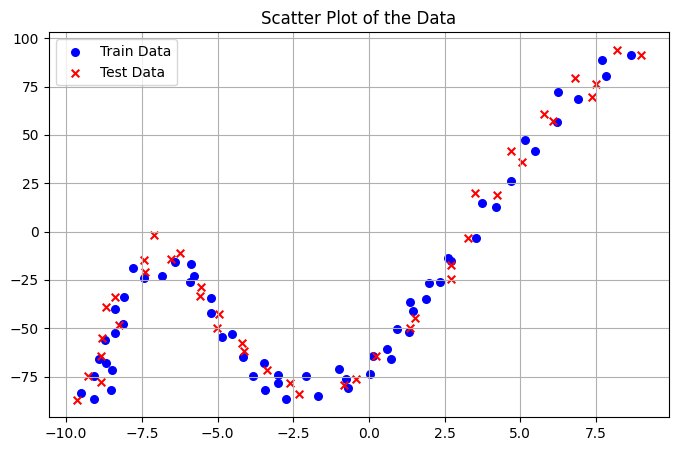

In [ ]:
def scatter_plot(train_data, train_labels, test_data, test_labels, legend1='Line1', legend2='Line2', title='Title'):
    plt.figure(figsize=(8, 5))
    plt.scatter(train_data, train_labels, s=30, marker='o', color='blue', label=legend1)
    plt.scatter(test_data, test_labels, s=30, marker='x', color='red', label=legend2)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

scatter_plot(X_train, y_train, X_test, y_test, legend1='Train Data', legend2='Test Data', title='Scatter Plot of the Data')

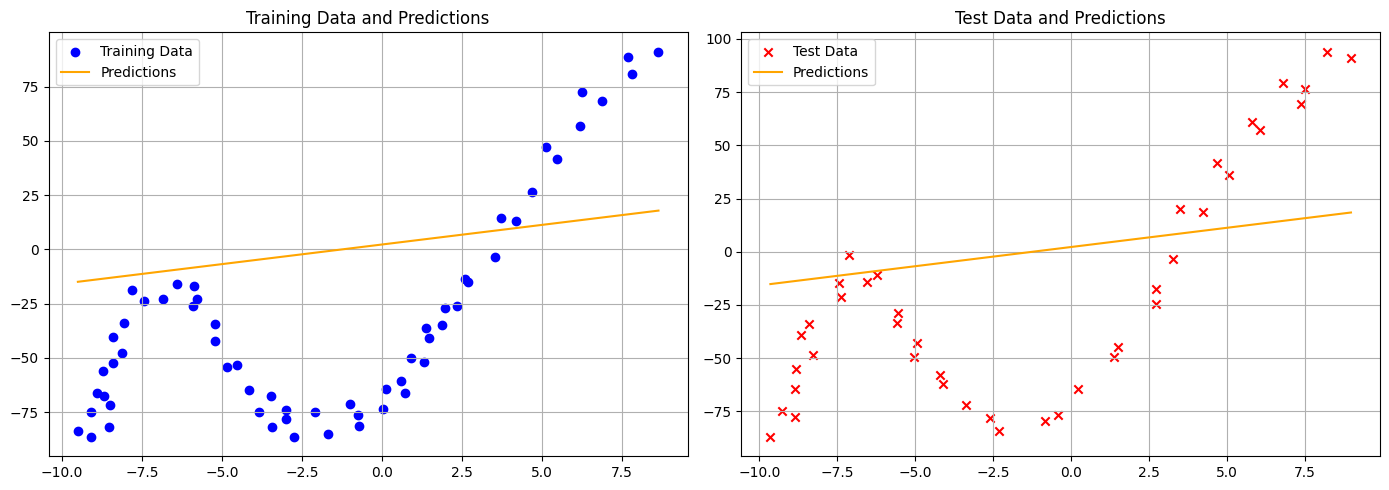

  Dataset        SSE      MSE   R^2
0   Train  166646.81  2777.45  0.49
1    Test   99178.56  2418.99  0.57


In [ ]:
ann = NeuralNetwork(input_size=1)
ann.train(X_train.reshape(-1, 1), y_train.reshape(-1, 1), epochs=5, learning_rate=0.001)

test_predictions = ann.predict(X_test.reshape(-1, 1))
train_predictions = ann.predict(X_train.reshape(-1, 1))
smooth_line_xtrain = np.linspace(X_train.min(), X_train.max(), 500)
smooth_line_ytrain = ann.predict(smooth_line_xtrain.reshape(-1, 1))
smooth_line_xtest = np.linspace(X_test.min(), X_test.max(), num=500)
smooth_line_ytest = ann.predict(smooth_line_xtest.reshape(-1, 1))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(X_train, y_train, color='blue', label='Training Data', marker='o')
axs[0].plot(smooth_line_xtrain, smooth_line_ytrain, color='orange', label='Predictions')
axs[0].set_title('Training Data and Predictions')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(X_test, y_test, color='red', label='Test Data', marker='x')
axs[1].plot(smooth_line_xtest, smooth_line_ytest, color='orange', label='Predictions')
axs[1].set_title('Test Data and Predictions')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

train_sse = ann.sse(y_train, train_predictions)
train_mse = ann.mse(y_train, train_predictions)
test_sse = ann.sse(y_test, test_predictions)
test_mse = ann.mse(y_test, test_predictions)

results = {
    'Dataset': ['Train', 'Test'],
    'SSE': [train_sse, test_sse],
    'MSE': [train_mse, test_mse],
    'R^2': [ann.r2(y_train, train_predictions), ann.r2(y_test, test_predictions)]
}

results_df = pd.DataFrame(results)

results_df['SSE'] = results_df['SSE'].apply(lambda x: f'{x:.2f}')
results_df['MSE'] = results_df['MSE'].apply(lambda x: f'{x:.2f}')
results_df['R^2'] = results_df['R^2'].apply(lambda x: f'{x:.2f}')

print(results_df)

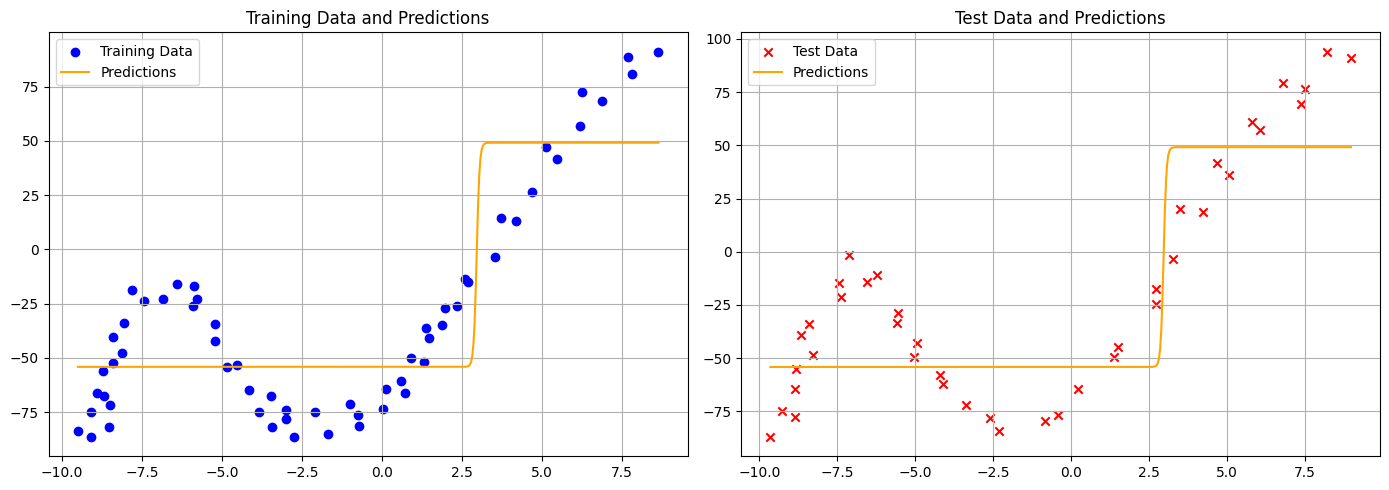

  Dataset       SSE     MSE   R^2
0   Train  36465.68  607.76  0.74
1    Test  29124.82  710.36  0.76


In [ ]:
ann = NeuralNetwork(input_size=1, hidden_size=1)
ann.train(X_train.reshape(-1, 1), y_train.reshape(-1, 1), epochs=100000, learning_rate=0.001)

test_predictions = ann.predict(X_test.reshape(-1, 1))
train_predictions = ann.predict(X_train.reshape(-1, 1))
smooth_line_xtrain = np.linspace(X_train.min(), X_train.max(), 500)
smooth_line_ytrain = ann.predict(smooth_line_xtrain.reshape(-1, 1))
smooth_line_xtest = np.linspace(X_test.min(), X_test.max(), num=500)
smooth_line_ytest = ann.predict(smooth_line_xtest.reshape(-1, 1))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(X_train, y_train, color='blue', label='Training Data', marker='o')
axs[0].plot(smooth_line_xtrain, smooth_line_ytrain, color='orange', label='Predictions')
axs[0].set_title('Training Data and Predictions')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(X_test, y_test, color='red', label='Test Data', marker='x')
axs[1].plot(smooth_line_xtest, smooth_line_ytest, color='orange', label='Predictions')
axs[1].set_title('Test Data and Predictions')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

train_sse = ann.sse(y_train, train_predictions)
train_mse = ann.mse(y_train, train_predictions)
test_sse = ann.sse(y_test, test_predictions)
test_mse = ann.mse(y_test, test_predictions)

results = {
    'Dataset': ['Train', 'Test'],
    'SSE': [train_sse, test_sse],
    'MSE': [train_mse, test_mse],
    'R^2': [ann.r2(y_train, train_predictions), ann.r2(y_test, test_predictions)]
}

results_df = pd.DataFrame(results)

results_df['SSE'] = results_df['SSE'].apply(lambda x: f'{x:.2f}')
results_df['MSE'] = results_df['MSE'].apply(lambda x: f'{x:.2f}')
results_df['R^2'] = results_df['R^2'].apply(lambda x: f'{x:.2f}')

print(results_df)

Trying different hidden units

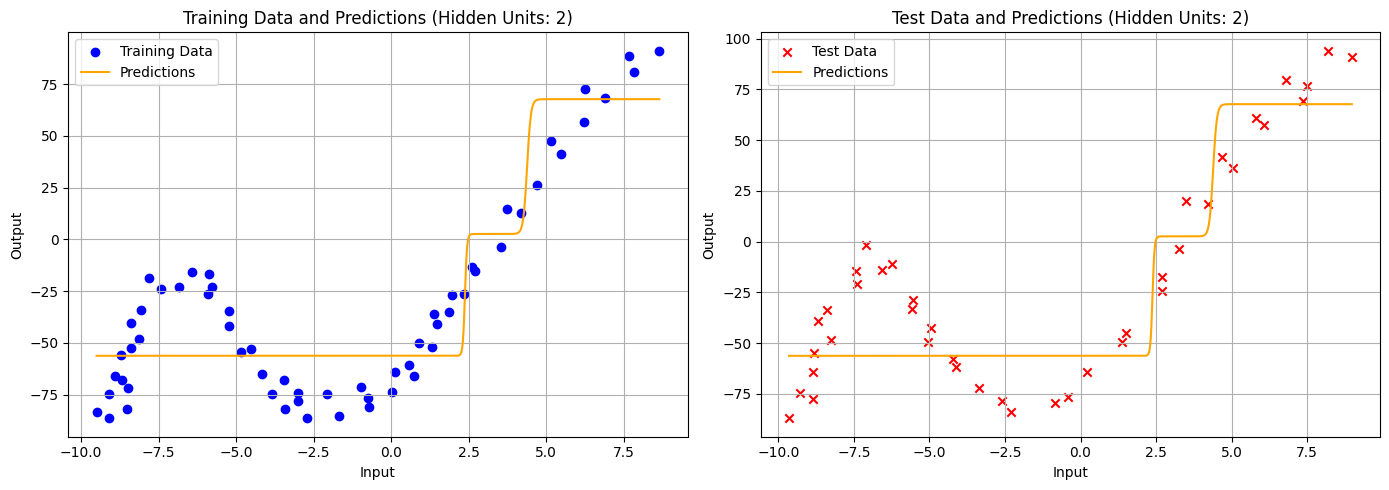

Hidden Units: 2
  Dataset       SSE     MSE   R^2
0   Train  26442.34  440.71  0.81
1    Test  21542.72  525.43  0.82


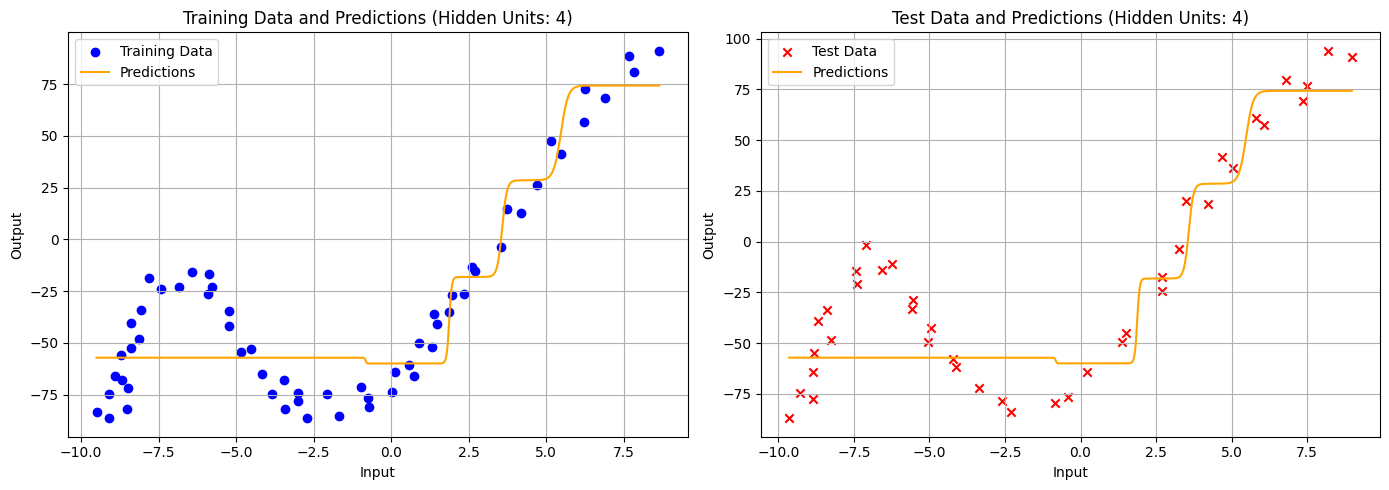

Hidden Units: 4
  Dataset       SSE     MSE   R^2
0   Train  21510.67  358.51  0.85
1    Test  19304.97  470.85  0.85


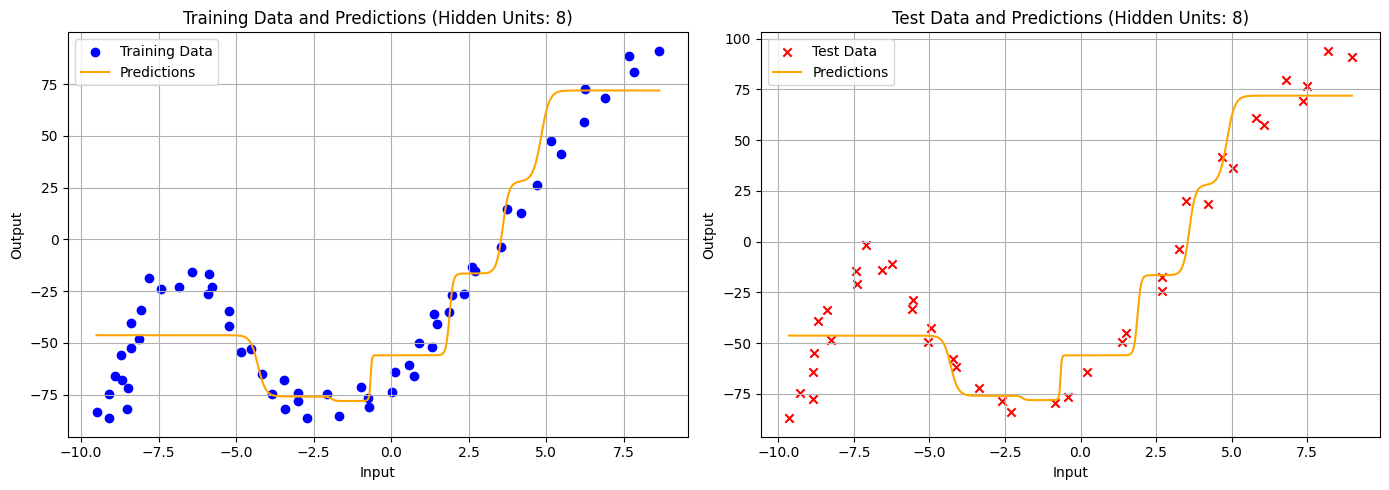

Hidden Units: 8
  Dataset       SSE     MSE   R^2
0   Train  16051.15  267.52  0.89
1    Test  14369.44  350.47  0.88


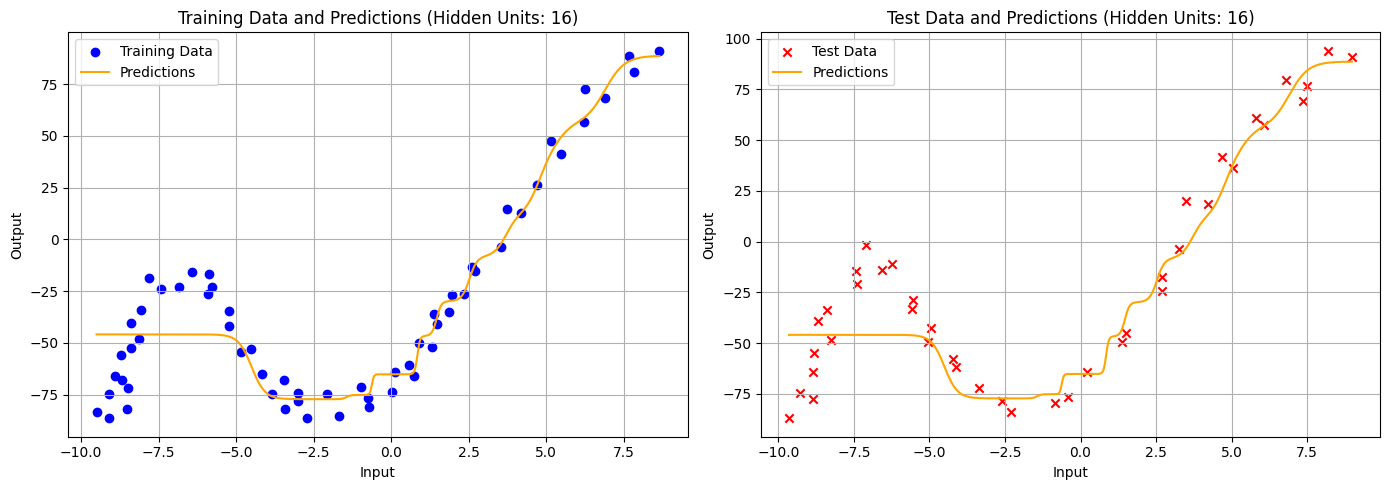

Hidden Units: 16
  Dataset       SSE     MSE   R^2
0   Train  12868.09  214.47  0.91
1    Test  12492.83  304.70  0.90


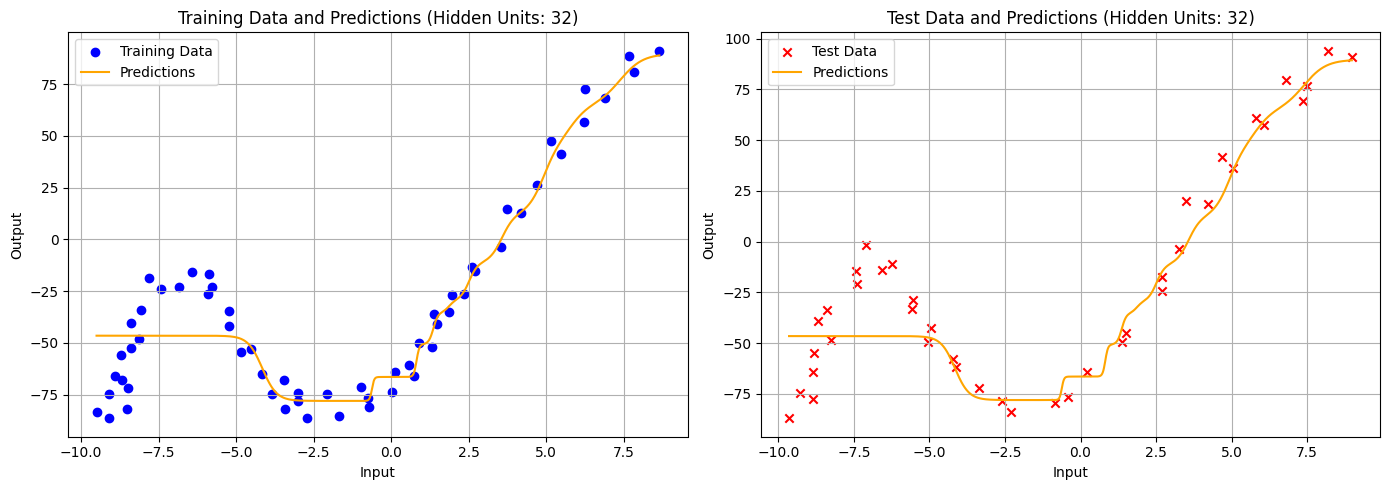

Hidden Units: 32
  Dataset       SSE     MSE   R^2
0   Train  12640.28  210.67  0.91
1    Test  12059.66  294.14  0.90


In [ ]:
hidden_units = [2, 4, 8, 16, 32]
for i in range(len(hidden_units)):
    hidden_unit_value = hidden_units[i]
    ann = NeuralNetwork(input_size=1, hidden_size=hidden_unit_value)
    ann.train(X_train.reshape(-1, 1), y_train.reshape(-1, 1), epochs=100000, learning_rate=0.001)

    test_predictions = ann.predict(X_test.reshape(-1, 1))
    train_predictions = ann.predict(X_train.reshape(-1, 1))
    smooth_line_xtrain = np.linspace(X_train.min(), X_train.max(), 1000)
    smooth_line_ytrain = ann.predict(smooth_line_xtrain.reshape(-1, 1))
    smooth_line_xtest = np.linspace(X_test.min(), X_test.max(), 1000)
    smooth_line_ytest = ann.predict(smooth_line_xtest.reshape(-1, 1))

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].scatter(X_train, y_train, color='blue', label='Training Data', marker='o')
    axs[0].plot(smooth_line_xtrain, smooth_line_ytrain, color='orange', label='Predictions')
    axs[0].set_xlabel('Input')
    axs[0].set_ylabel('Output')
    axs[0].set_title(f'Training Data and Predictions (Hidden Units: {hidden_unit_value})')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].scatter(X_test, y_test, color='red', label='Test Data', marker='x')
    axs[1].plot(smooth_line_xtest, smooth_line_ytest, color='orange', label='Predictions')
    axs[1].set_xlabel('Input')
    axs[1].set_ylabel('Output')
    axs[1].set_title(f'Test Data and Predictions (Hidden Units: {hidden_unit_value})')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    train_sse = ann.sse(y_train, train_predictions)
    train_mse = ann.mse(y_train, train_predictions)
    test_sse = ann.sse(y_test, test_predictions)
    test_mse = ann.mse(y_test, test_predictions)

    results = {
        'Dataset': ['Train', 'Test'],
        'SSE': [train_sse, test_sse],
        'MSE': [train_mse, test_mse],
        'R^2': [ann.r2(y_train, train_predictions), ann.r2(y_test, test_predictions)]
    }

    results_df = pd.DataFrame(results)

    results_df['SSE'] = results_df['SSE'].apply(lambda x: f'{x:.2f}')
    results_df['MSE'] = results_df['MSE'].apply(lambda x: f'{x:.2f}')
    results_df['R^2'] = results_df['R^2'].apply(lambda x: f'{x:.2f}')

    print(f'Hidden Units: {hidden_unit_value}')
    print(results_df)

Trying different learning rates

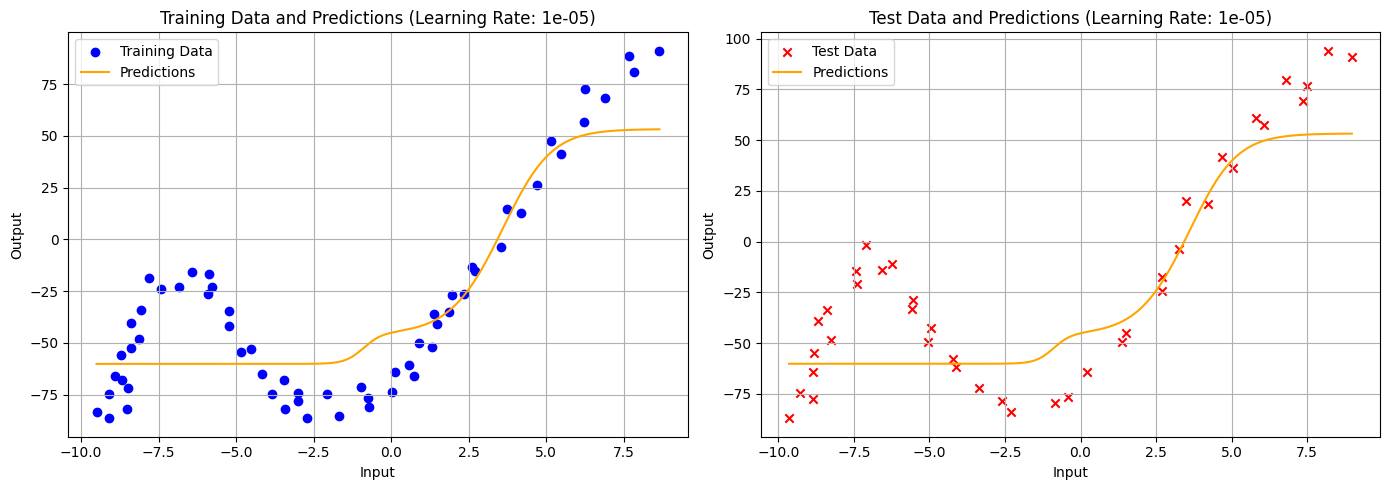

Learning Rate: 1e-05
  Dataset       SSE     MSE   R^2
0   Train  27116.37  451.94  0.81
1    Test  24828.23  605.57  0.82


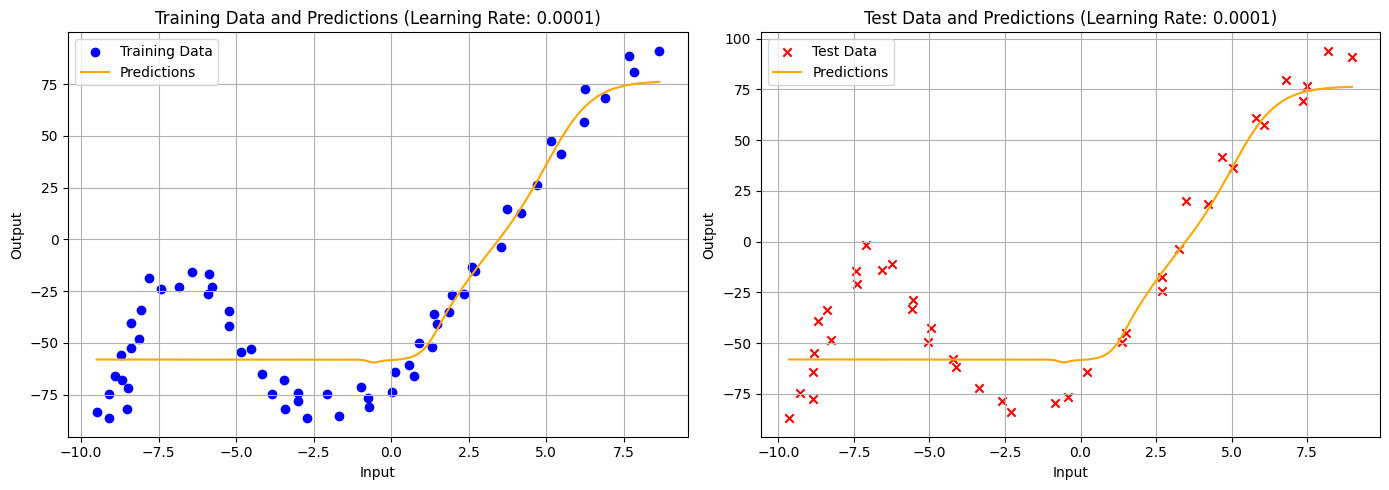

Learning Rate: 0.0001
  Dataset       SSE     MSE   R^2
0   Train  20034.46  333.91  0.86
1    Test  18406.20  448.93  0.85


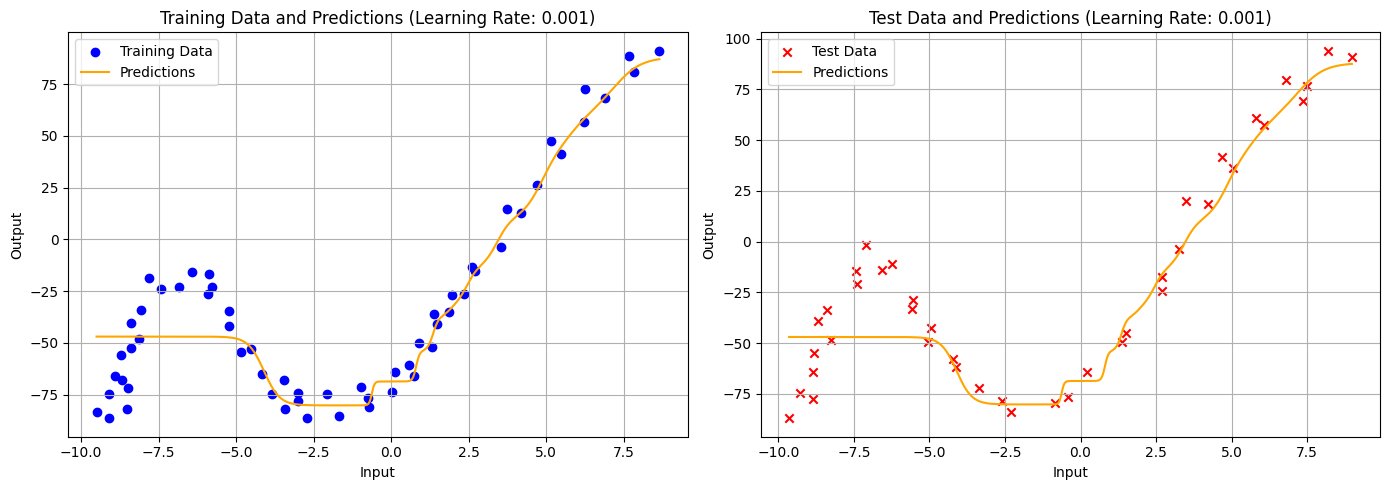

Learning Rate: 0.001
  Dataset       SSE     MSE   R^2
0   Train  12802.73  213.38  0.91
1    Test  12020.89  293.19  0.90


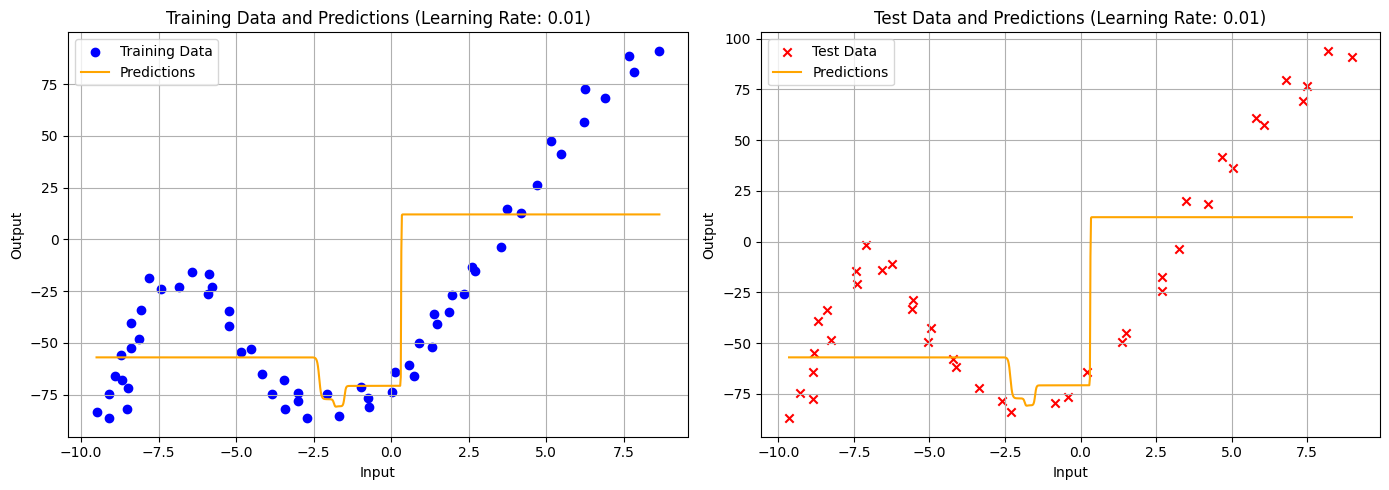

Learning Rate: 0.01
  Dataset       SSE      MSE   R^2
0   Train  75936.27  1265.60  0.46
1    Test  55891.90  1363.22  0.59


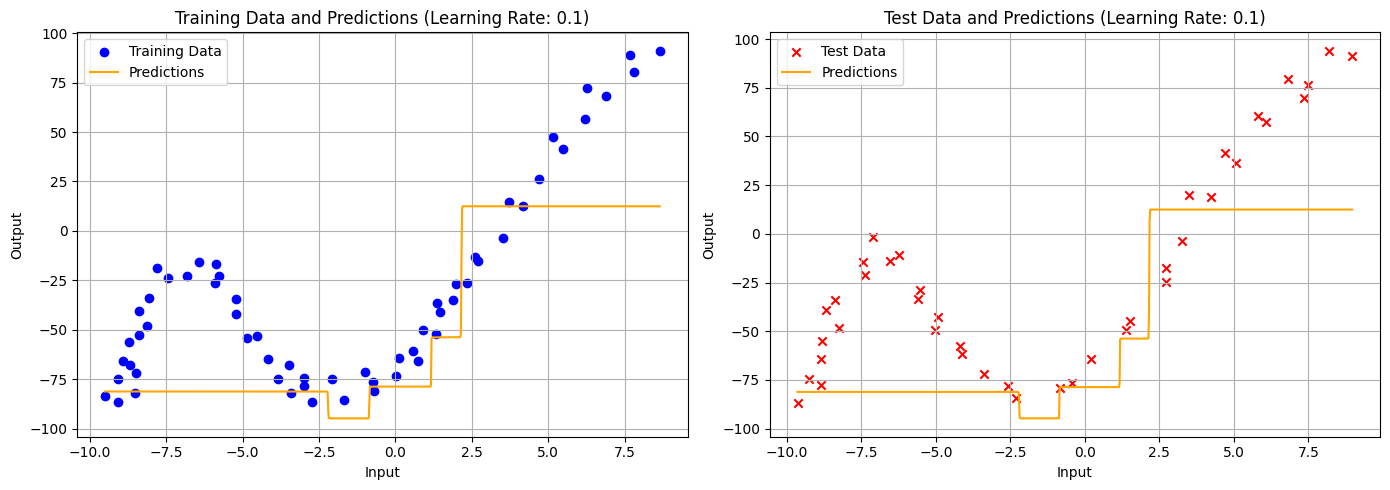

Learning Rate: 0.1
  Dataset       SSE      MSE   R^2
0   Train  73146.85  1219.11  0.70
1    Test  71806.51  1751.38  0.68


In [ ]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
for i in range(len(learning_rates)):
    learning_rate_value = learning_rates[i]
    ann = NeuralNetwork(input_size=1, hidden_size=32)
    ann.train(X_train.reshape(-1, 1), y_train.reshape(-1, 1), epochs=100000, learning_rate=learning_rate_value)

    test_predictions = ann.predict(X_test.reshape(-1, 1))
    train_predictions = ann.predict(X_train.reshape(-1, 1))
    smooth_line_xtrain = np.linspace(X_train.min(), X_train.max(), 1000)
    smooth_line_ytrain = ann.predict(smooth_line_xtrain.reshape(-1, 1))
    smooth_line_xtest = np.linspace(X_test.min(), X_test.max(), 1000)
    smooth_line_ytest = ann.predict(smooth_line_xtest.reshape(-1, 1))

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].scatter(X_train, y_train, color='blue', label='Training Data', marker='o')
    axs[0].plot(smooth_line_xtrain, smooth_line_ytrain, color='orange', label='Predictions')
    axs[0].set_xlabel('Input')
    axs[0].set_ylabel('Output')
    axs[0].set_title(f'Training Data and Predictions (Learning Rate: {learning_rate_value})')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].scatter(X_test, y_test, color='red', label='Test Data', marker='x')
    axs[1].plot(smooth_line_xtest, smooth_line_ytest, color='orange', label='Predictions')
    axs[1].set_xlabel('Input')
    axs[1].set_ylabel('Output')
    axs[1].set_title(f'Test Data and Predictions (Learning Rate: {learning_rate_value})')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    train_sse = ann.sse(y_train, train_predictions)
    train_mse = ann.mse(y_train, train_predictions)
    test_sse = ann.sse(y_test, test_predictions)
    test_mse = ann.mse(y_test, test_predictions)

    results = {
        'Dataset': ['Train', 'Test'],
        'SSE': [train_sse, test_sse],
        'MSE': [train_mse, test_mse],
        'R^2': [ann.r2(y_train, train_predictions), ann.r2(y_test, test_predictions)]
    }

    results_df = pd.DataFrame(results)

    results_df['SSE'] = results_df['SSE'].apply(lambda x: f'{x:.2f}')
    results_df['MSE'] = results_df['MSE'].apply(lambda x: f'{x:.2f}')
    results_df['R^2'] = results_df['R^2'].apply(lambda x: f'{x:.2f}')

    print(f'Learning Rate: {learning_rate_value}')
    print(results_df)

Trying different number of Epochs

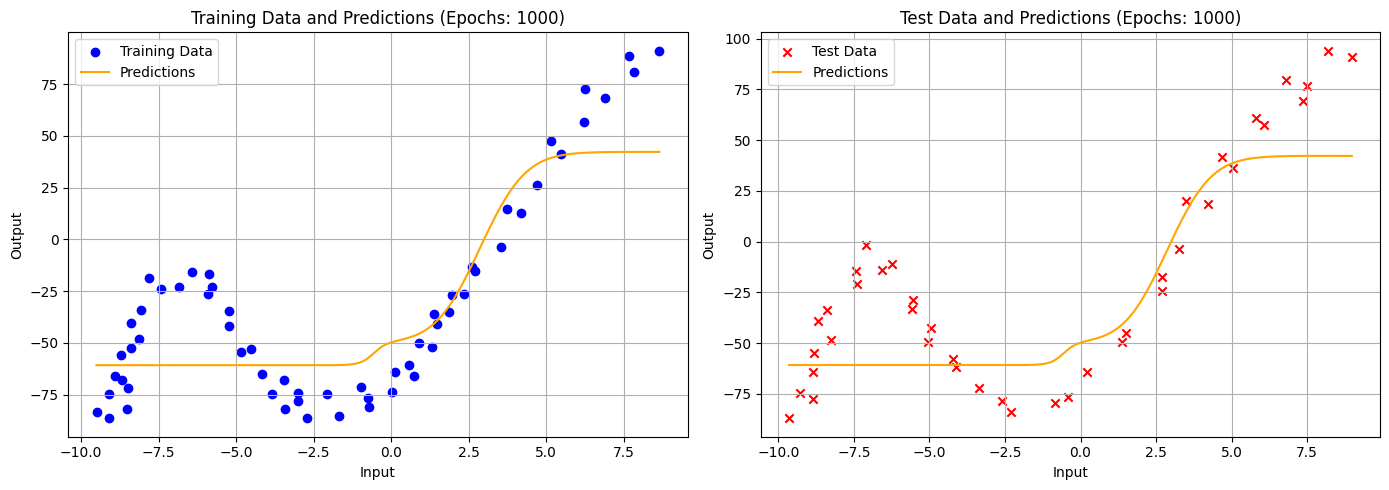

Epochs: 1000
  Dataset       SSE     MSE   R^2
0   Train  29770.56  496.18  0.80
1    Test  28611.73  697.85  0.80


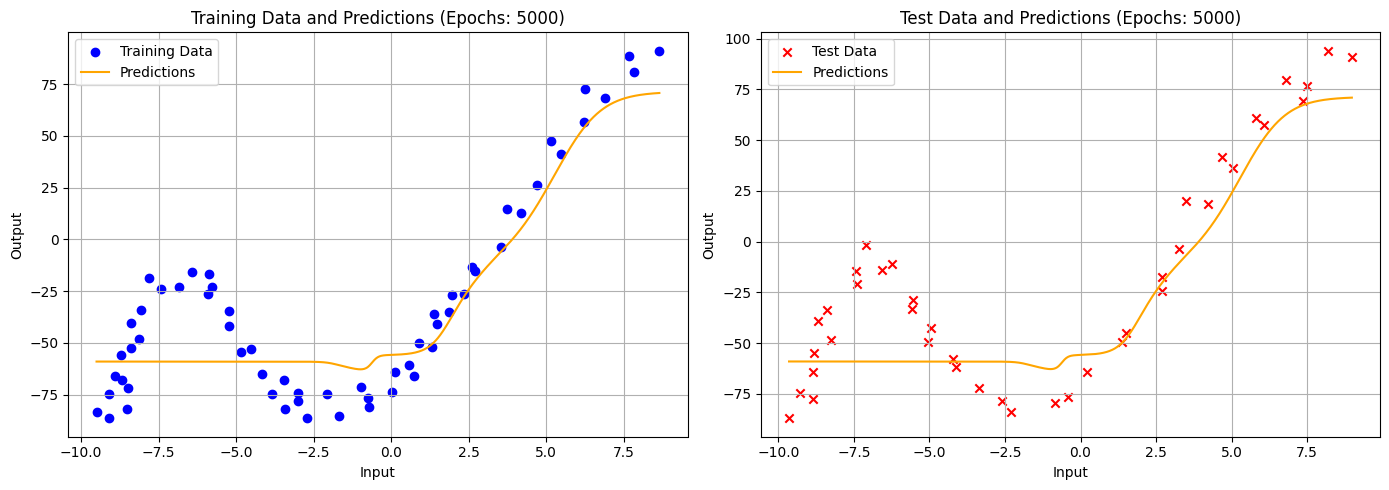

Epochs: 5000
  Dataset       SSE     MSE   R^2
0   Train  21670.69  361.18  0.86
1    Test  20787.65  507.02  0.85


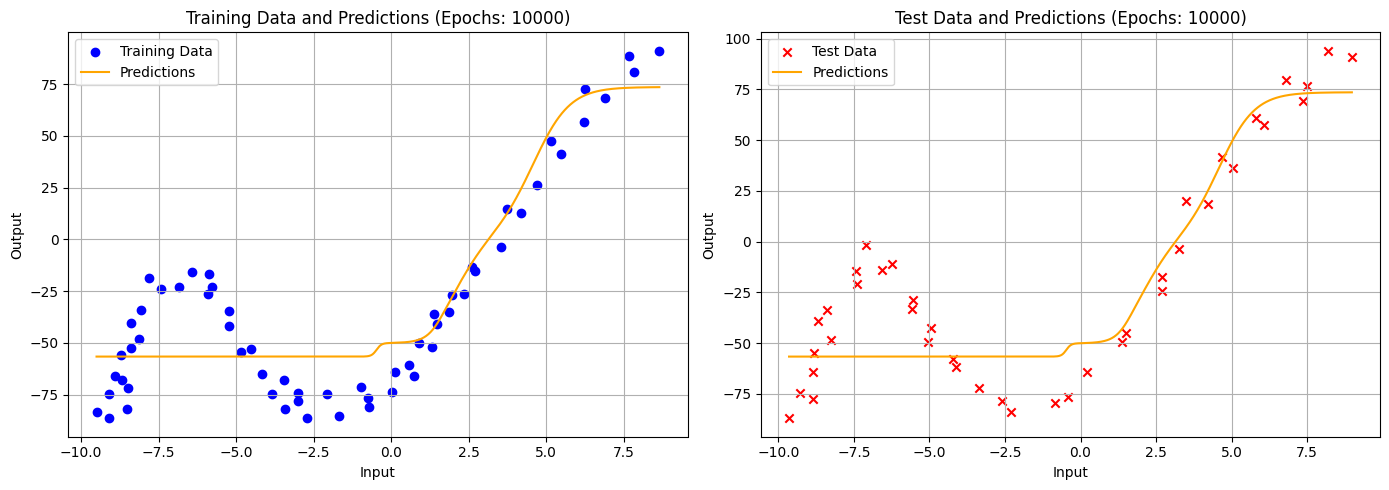

Epochs: 10000
  Dataset       SSE     MSE   R^2
0   Train  21822.51  363.71  0.85
1    Test  18728.06  456.78  0.84


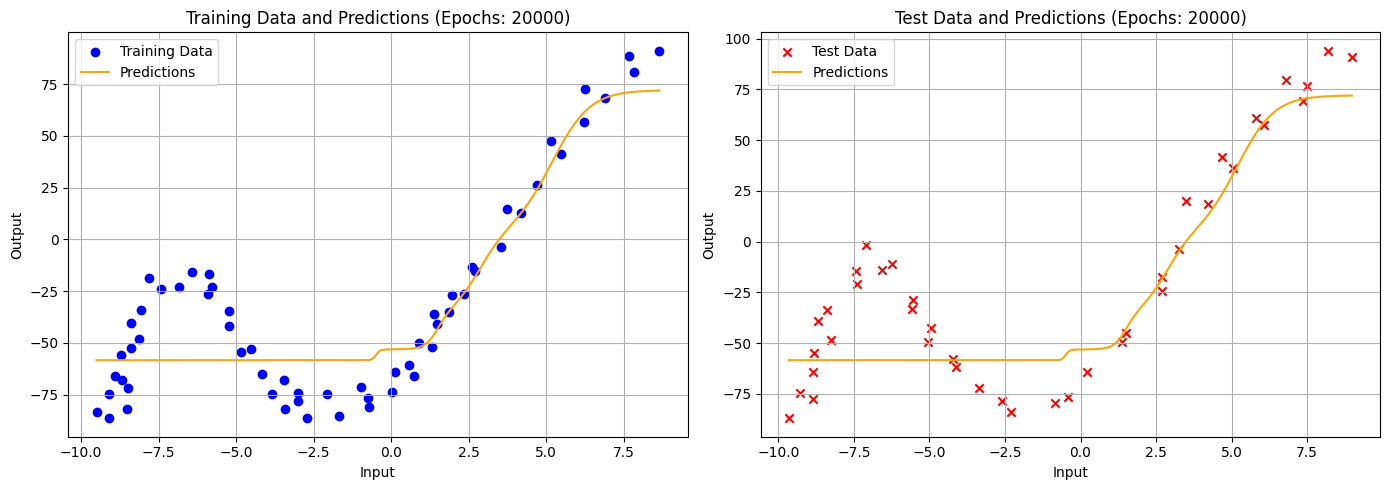

Epochs: 20000
  Dataset       SSE     MSE   R^2
0   Train  20950.19  349.17  0.85
1    Test  19332.77  471.53  0.85


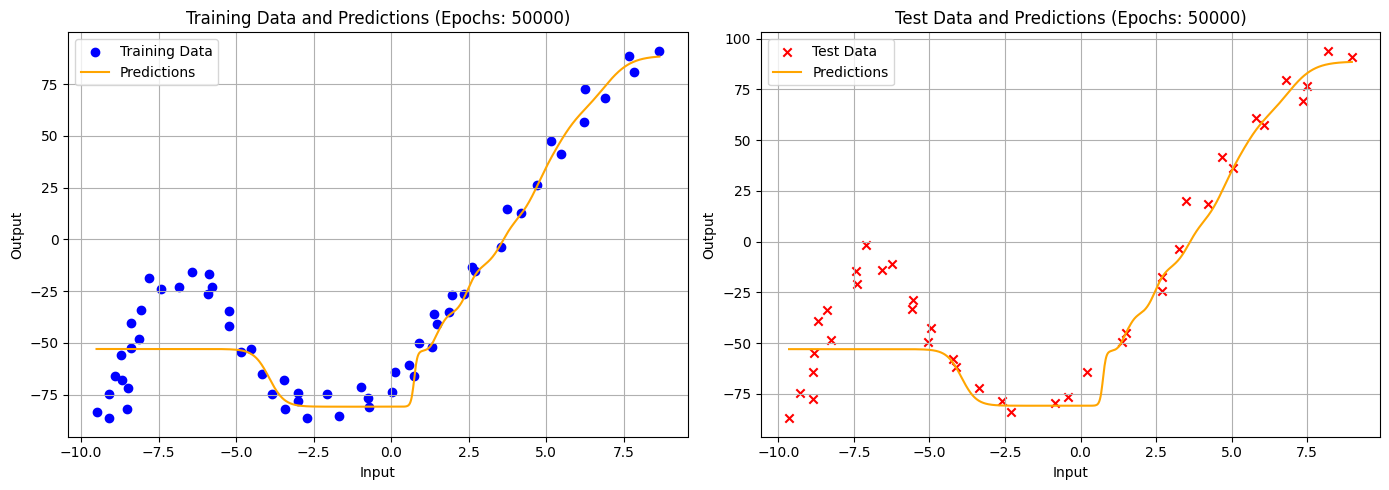

Epochs: 50000
  Dataset       SSE     MSE   R^2
0   Train  14244.16  237.40  0.91
1    Test  14044.88  342.56  0.90


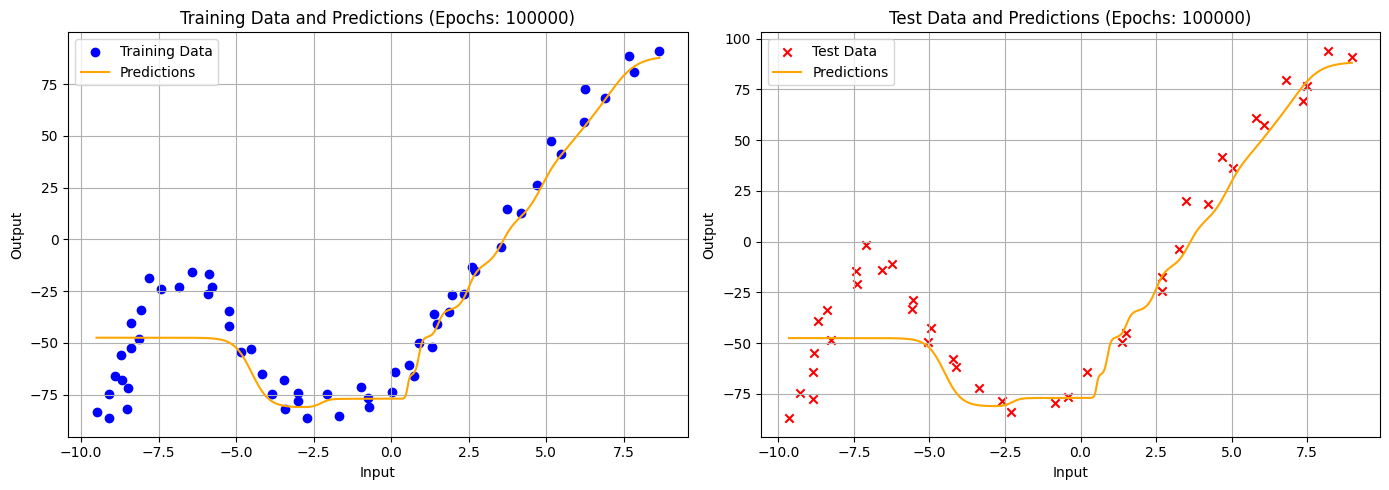

Epochs: 100000
  Dataset       SSE     MSE   R^2
0   Train  13524.13  225.40  0.91
1    Test  13249.50  323.16  0.90


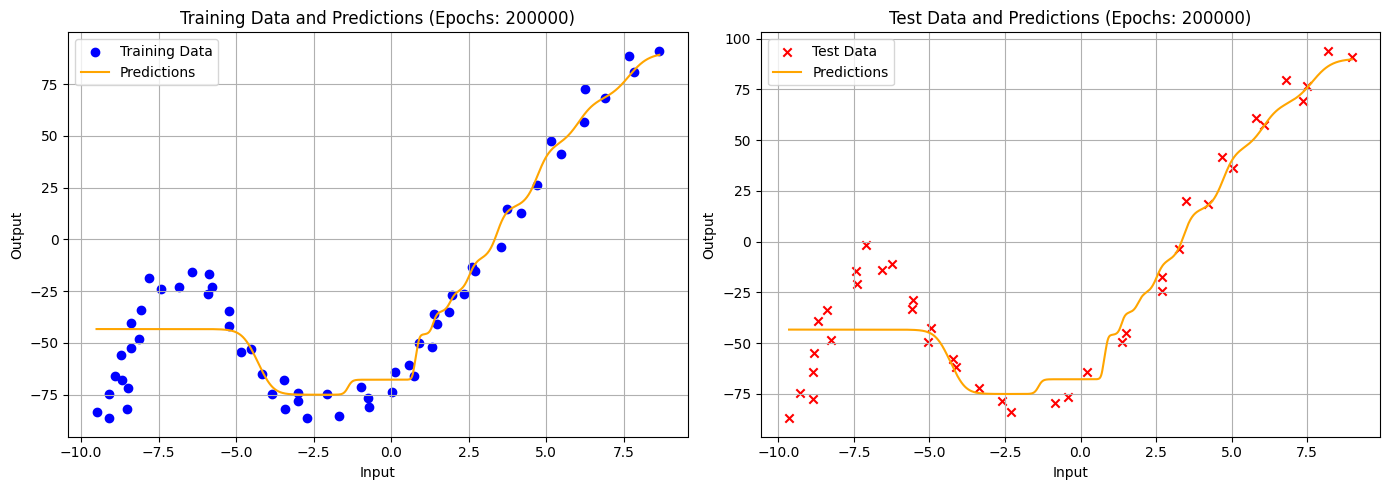

Epochs: 200000
  Dataset       SSE     MSE   R^2
0   Train  13334.56  222.24  0.91
1    Test  11461.03  279.54  0.90


In [ ]:
epochs = [1000, 5000, 10000, 20000, 50000, 100000, 200000]
for i in range(len(epochs)):
    epoch_value = epochs[i]
    ann = NeuralNetwork(input_size=1, hidden_size=32)
    ann.train(X_train.reshape(-1, 1), y_train.reshape(-1, 1), epochs=epochs[i], learning_rate=0.001)

    test_predictions = ann.predict(X_test.reshape(-1, 1))
    train_predictions = ann.predict(X_train.reshape(-1, 1))
    smooth_line_xtrain = np.linspace(X_train.min(), X_train.max(), 1000)
    smooth_line_ytrain = ann.predict(smooth_line_xtrain.reshape(-1, 1))
    smooth_line_xtest = np.linspace(X_test.min(), X_test.max(), 1000)
    smooth_line_ytest = ann.predict(smooth_line_xtest.reshape(-1, 1))

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].scatter(X_train, y_train, color='blue', label='Training Data', marker='o')
    axs[0].plot(smooth_line_xtrain, smooth_line_ytrain, color='orange', label='Predictions')
    axs[0].set_xlabel('Input')
    axs[0].set_ylabel('Output')
    axs[0].set_title(f'Training Data and Predictions (Epochs: {epoch_value})')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].scatter(X_test, y_test, color='red', label='Test Data', marker='x')
    axs[1].plot(smooth_line_xtest, smooth_line_ytest, color='orange', label='Predictions')
    axs[1].set_xlabel('Input')
    axs[1].set_ylabel('Output')
    axs[1].set_title(f'Test Data and Predictions (Epochs: {epoch_value})')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    train_sse = ann.sse(y_train, train_predictions)
    train_mse = ann.mse(y_train, train_predictions)
    test_sse = ann.sse(y_test, test_predictions)
    test_mse = ann.mse(y_test, test_predictions)

    results = {
        'Dataset': ['Train', 'Test'],
        'SSE': [train_sse, test_sse],
        'MSE': [train_mse, test_mse],
        'R^2': [ann.r2(y_train, train_predictions), ann.r2(y_test, test_predictions)]
    }

    results_df = pd.DataFrame(results)

    results_df['SSE'] = results_df['SSE'].apply(lambda x: f'{x:.2f}')
    results_df['MSE'] = results_df['MSE'].apply(lambda x: f'{x:.2f}')
    results_df['R^2'] = results_df['R^2'].apply(lambda x: f'{x:.2f}')

    print(f'Epochs: {epoch_value}')
    print(results_df)

Epochs = 200000, learning rate = 0.001, hidden units = 32, without normalization Test SSE = 11461.03

With Normalization

In [5]:
normalize = True

if normalize:
    mean_data = np.mean(X_train, axis=0)
    std_data = np.std(X_train, axis=0)
    mean_data_y = np.mean(y_train, axis=0)
    std_data_y = np.std(y_train, axis=0)

    X_train_normal = (X_train - mean_data) / std_data
    X_test_normal = (X_test - mean_data) / std_data
    y_train_normal = (y_train - mean_data_y) / std_data_y
    y_test_normal = (y_test - mean_data_y) / std_data_y

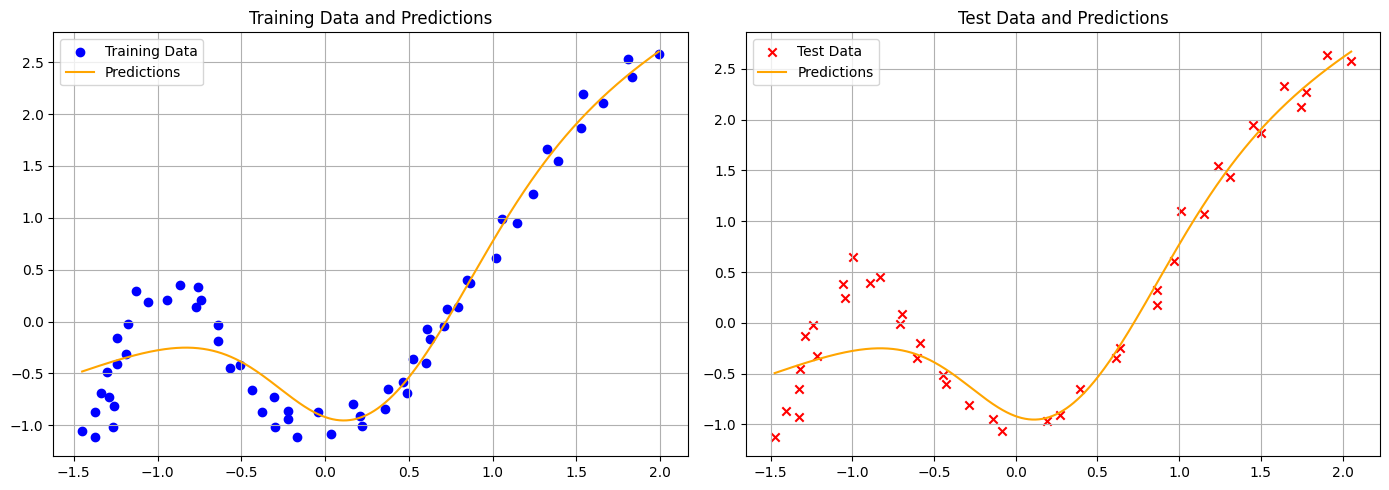

  Dataset   SSE   MSE   R^2
0   Train  4.87  0.08  0.92
1    Test  4.25  0.10  0.92


In [ ]:
ann = NeuralNetwork(input_size=1, hidden_size=32)
ann.train(X_train_normal.reshape(-1, 1), y_train_normal.reshape(-1, 1), epochs=200000, learning_rate=0.001)

test_predictions = ann.predict(X_test_normal.reshape(-1, 1))
train_predictions = ann.predict(X_train_normal.reshape(-1, 1))
smooth_line_xtrain = np.linspace(X_train_normal.min(), X_train_normal.max(), 1000)
smooth_line_ytrain = ann.predict(smooth_line_xtrain.reshape(-1, 1))
smooth_line_xtest = np.linspace(X_test_normal.min(), X_test_normal.max(), 1000)
smooth_line_ytest = ann.predict(smooth_line_xtest.reshape(-1, 1))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(X_train_normal, y_train_normal, color='blue', label='Training Data', marker='o')
axs[0].plot(smooth_line_xtrain, smooth_line_ytrain, color='orange', label='Predictions')
axs[0].set_title(f'Training Data and Predictions')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(X_test_normal, y_test_normal, color='red', label='Test Data', marker='x')
axs[1].plot(smooth_line_xtest, smooth_line_ytest, color='orange', label='Predictions')
axs[1].set_title(f'Test Data and Predictions')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

train_sse = ann.sse(y_train_normal, train_predictions)
train_mse = ann.mse(y_train_normal, train_predictions)
test_sse = ann.sse(y_test_normal, test_predictions)
test_mse = ann.mse(y_test_normal, test_predictions)

results = {
    'Dataset': ['Train', 'Test'],
    'SSE': [train_sse, test_sse],
    'MSE': [train_mse, test_mse],
    'R^2': [ann.r2(y_train_normal, train_predictions), ann.r2(y_test_normal, test_predictions)]
}

results_df = pd.DataFrame(results)

results_df['SSE'] = results_df['SSE'].apply(lambda x: f'{x:.2f}')
results_df['MSE'] = results_df['MSE'].apply(lambda x: f'{x:.2f}')
results_df['R^2'] = results_df['R^2'].apply(lambda x: f'{x:.2f}')

print(results_df)

In [ ]:
hidden_units = [2, 4, 8, 16, 32]
learning_rates = [0.001, 0.01, 0.1]
epochs = [1000, 5000, 10000, 20000, 50000, 100000, 200000]

best_sse = float('inf')
best_hidden_units = None
best_learning_rate = None
best_epochs = None

for hidden_unit in hidden_units:
    for learning_rate in learning_rates:
        for epoch_value in epochs:
            ann = NeuralNetwork(input_size=1, hidden_size=hidden_unit)
            ann.train(X_train.reshape(-1, 1), y_train.reshape(-1, 1), epochs=epoch_value, learning_rate=learning_rate)

            test_predictions = ann.predict(X_test.reshape(-1, 1))
            train_predictions = ann.predict(X_train.reshape(-1, 1))
            sse = ann.sse(y_train, train_predictions)
            mse = ann.mse(y_train, train_predictions)

            if sse < best_sse:
                best_sse = sse
                best_mse = mse
                best_hidden_units = hidden_unit
                best_learning_rate = learning_rate
                best_epochs = epoch_value


print(f'Best SSE: {best_sse:.2f}')
print(f'Best MSE: {best_mse:.2f}')
print(f'Hidden Units: {best_hidden_units}')
print(f'Learning Rate: {best_learning_rate}')
print(f'Epochs: {best_epochs}')


<ipython-input-29-2c8cd3657abb>:68: RuntimeWarning: overflow encountered in matmul
  hidden_error = output_error @ self.w_hidden_output.T
<ipython-input-29-2c8cd3657abb>:69: RuntimeWarning: invalid value encountered in multiply
  hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_layer_output)


Best SSE: 12694.12
Best MSE: 211.57
Hidden Units: 32
Learning Rate: 0.001
Epochs: 200000


In [ ]:
# def scale_data(train_input, test_input, train_output, test_output):
#     X = np.concatenate((X_train, X_test))
#     X_mean = np.mean(X)
#     X_centered = X - X_mean
#     X_min = np.min(X_centered)
#     X_max = np.max(X_centered)
#     X_scaled = (X_centered - X_min) / (X_max - X_min)

#     y = np.concatenate((y_train, y_test))
#     y_mean = np.mean(y)
#     y_centered = y - y_mean
#     y_min = np.min(y_centered)
#     y_max = np.max(y_centered)
#     y_scaled = (y_centered - y_min) / (y_max - y_min)

#     X_train_scaled = X_scaled[:len(train_input)]
#     X_test_scaled = X_scaled[len(train_input):]
#     y_train_scaled = y_scaled[:len(train_output)]
#     y_test_scaled = y_scaled[len(train_output):]

#     return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale_data(X_train, X_test, y_train, y_test)

# def reverse_scale(min, max, arr):
#     arr = (arr * (max - min)) + min
#     return arr

Part C)

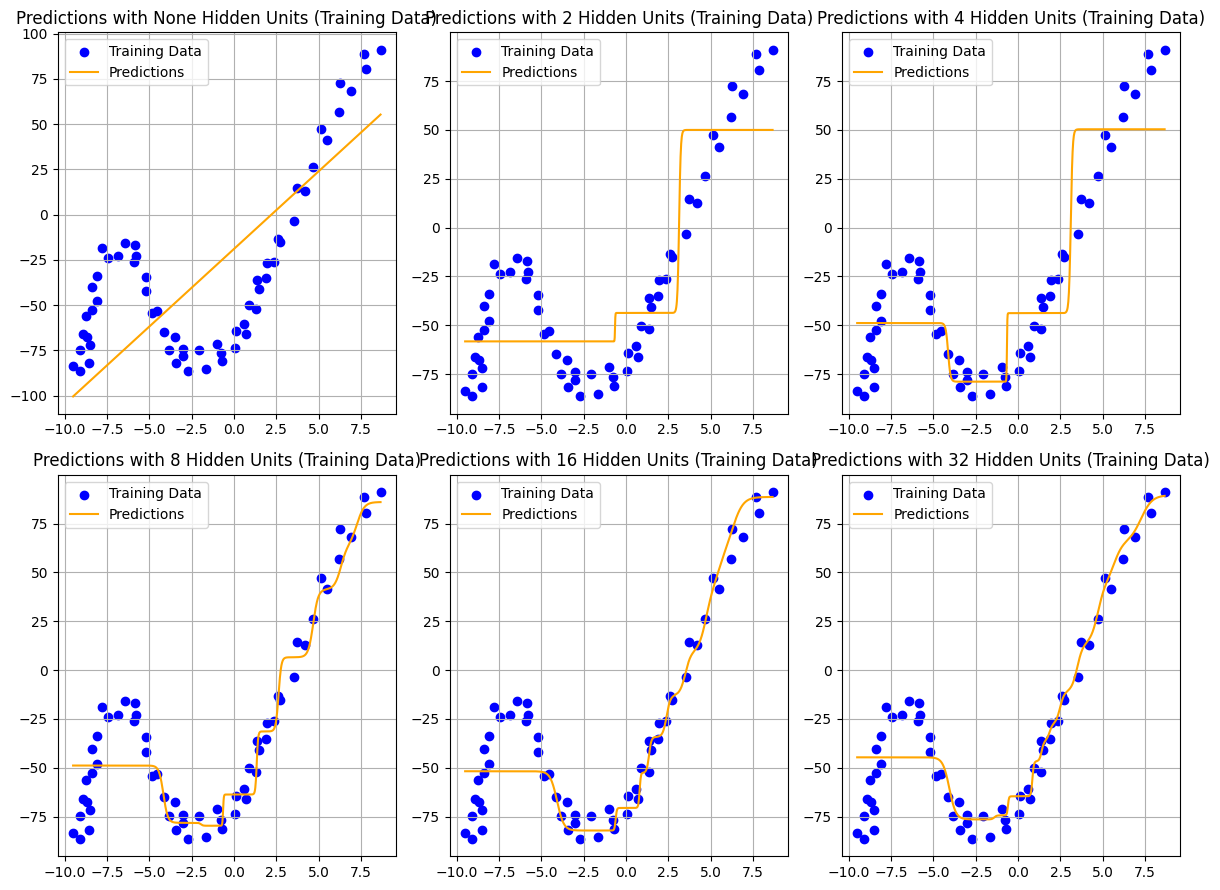

  Hidden Units Train MSE Test MSE    Train STD     Test STD    Train SSE  \
0         None       NaN      NaN  1082.764889  1415.128084  1330.522465   
1            2       NaN      NaN   580.460982   757.231842   576.071566   
2            4       NaN      NaN   559.395077   645.410153   465.080501   
3            8       NaN      NaN   355.671228   494.545559   223.902096   
4           16       NaN      NaN   363.327157   550.650515   227.215489   
5           32       NaN      NaN   385.625584   470.913304   214.851241   

      Test SSE  
0  1503.097038  
1   718.958166  
2   582.186432  
3   333.556757  
4   338.745364  
5   282.081574  


In [12]:
hidden_unit_counts = [None, 2, 4, 8, 16, 32]
epochs = 200000
learning_rate = 0.001

results_df = pd.DataFrame(columns=['Hidden Units', 'Train MSE', 'Test MSE', 'Train STD', 'Test STD'])

fig, axs = plt.subplots(2, 3, figsize=(12, 9))

for i, num_hidden_units in enumerate(hidden_unit_counts):
    ann = NeuralNetwork(input_size=1, hidden_size=num_hidden_units)
    ann.train(X_train.reshape(-1, 1), y_train.reshape(-1, 1), epochs=epochs, learning_rate=learning_rate)

    smooth_x = np.linspace(X_train.min(), X_train.max(), 1000)
    smooth_y = ann.predict(smooth_x.reshape(-1, 1))
    train_predictions = ann.predict(X_train.reshape(-1, 1))
    test_predictions = ann.predict(X_test.reshape(-1, 1))

    train_sse = ann.sse(y_train, train_predictions) / 60
    test_sse = ann.sse(y_test, test_predictions) / 41
    train_std = ann.std_dev(y_train, train_predictions)
    test_std = ann.std_dev(y_test, test_predictions)

    new_row = pd.DataFrame({
        'Hidden Units': [num_hidden_units],
        'Train SSE': [train_sse],
        'Test SSE': [test_sse],
        'Train STD': [train_std],
        'Test STD': [test_std]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    ax = axs[i // 3, i % 3]
    ax.scatter(X_train, y_train, color='blue', label='Training Data', marker='o')
    ax.plot(smooth_x, smooth_y, color='orange', label='Predictions')
    ax.legend()
    ax.set_title(f'Predictions with {num_hidden_units} Hidden Units (Training Data)')
    ax.grid(True)

plt.tight_layout()
plt.show()

print(results_df)